In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso
from tqdm import tqdm


ModuleNotFoundError: No module named 'seaborn'

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik
import plotly.express as px
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_predict, cross_val_score, train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA

In [2]:
df = pd.read_parquet(r"C:\Users\1213i\Desktop\DS\project\data\raw\dataset.parquet")

In [3]:
len(df)

442961

In [4]:
df.shape

(442961, 78)

In [5]:
df = df.drop_duplicates()

In [6]:
len(df)

442961

In [6]:
df = df.set_index('borrow_block_number')

In [8]:
df.head(5)

,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,avg_gas_paid_per_tx_eth,...,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count,target
borrow_block_number,,,,,,,,,,,,,,,,,,,,,
7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973049.0,199,438,-239,0.397391,0.000981,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,1
7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973188.0,200,439,-239,0.399063,0.000983,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973238.0,201,440,-239,0.400895,0.000985,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,1.557191e+09,1.557198e+09,13922.0,8,56,-48,0.604001,0.010786,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,0
7712572,1.557217e+09,0xbd9ed130a53cfafcf81502e4d35329a6c4d53410,1.557217e+09,1.557217e+09,264.0,2,3,-1,0.003008,0.001003,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,0


In [9]:
df.isna().sum().sum()

np.int64(0)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442961 entries, 7711117 to 18251921
Data columns (total 77 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   borrow_timestamp                         442961 non-null  float64
 1   wallet_address                           442961 non-null  object 
 2   first_tx_timestamp                       442961 non-null  float64
 3   last_tx_timestamp                        442961 non-null  float64
 4   wallet_age                               442961 non-null  float64
 5   incoming_tx_count                        442961 non-null  int64  
 6   outgoing_tx_count                        442961 non-null  int64  
 7   net_incoming_tx_count                    442961 non-null  int64  
 8   total_gas_paid_eth                       442961 non-null  float64
 9   avg_gas_paid_per_tx_eth                  442961 non-null  float64
 10  risky_tx_count               

In [62]:
df['target'].value_counts()

target
0    276761
1    166200
Name: count, dtype: int64

In [12]:
df.columns

Index(['borrow_timestamp', 'wallet_address', 'first_tx_timestamp',
       'last_tx_timestamp', 'wallet_age', 'incoming_tx_count',
       'outgoing_tx_count', 'net_incoming_tx_count', 'total_gas_paid_eth',
       'avg_gas_paid_per_tx_eth', 'risky_tx_count',
       'risky_unique_contract_count', 'risky_first_tx_timestamp',
       'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
       'risky_sum_outgoing_amount_eth', 'outgoing_tx_sum_eth',
       'incoming_tx_sum_eth', 'outgoing_tx_avg_eth', 'incoming_tx_avg_eth',
       'max_eth_ever', 'min_eth_ever', 'total_balance_eth', 'risk_factor',
       'total_collateral_eth', 'total_collateral_avg_eth',
       'total_available_borrows_eth', 'total_available_borrows_avg_eth',
       'avg_weighted_risk_factor', 'risk_factor_above_threshold_daily_count',
       'avg_risk_factor', 'max_risk_factor', 'borrow_amount_sum_eth',
       'borrow_amount_avg_eth', 'borrow_count', 'repay_amount_sum_eth',
       'repay_amount_avg_eth', 'repay_c

array([[<Axes: title={'center': 'borrow_timestamp'}>,
        <Axes: title={'center': 'first_tx_timestamp'}>,
        <Axes: title={'center': 'last_tx_timestamp'}>,
        <Axes: title={'center': 'wallet_age'}>,
        <Axes: title={'center': 'incoming_tx_count'}>,
        <Axes: title={'center': 'outgoing_tx_count'}>,
        <Axes: title={'center': 'net_incoming_tx_count'}>,
        <Axes: title={'center': 'total_gas_paid_eth'}>,
        <Axes: title={'center': 'avg_gas_paid_per_tx_eth'}>],
       [<Axes: title={'center': 'risky_tx_count'}>,
        <Axes: title={'center': 'risky_unique_contract_count'}>,
        <Axes: title={'center': 'risky_first_tx_timestamp'}>,
        <Axes: title={'center': 'risky_last_tx_timestamp'}>,
        <Axes: title={'center': 'risky_first_last_tx_timestamp_diff'}>,
        <Axes: title={'center': 'risky_sum_outgoing_amount_eth'}>,
        <Axes: title={'center': 'outgoing_tx_sum_eth'}>,
        <Axes: title={'center': 'incoming_tx_sum_eth'}>,
       

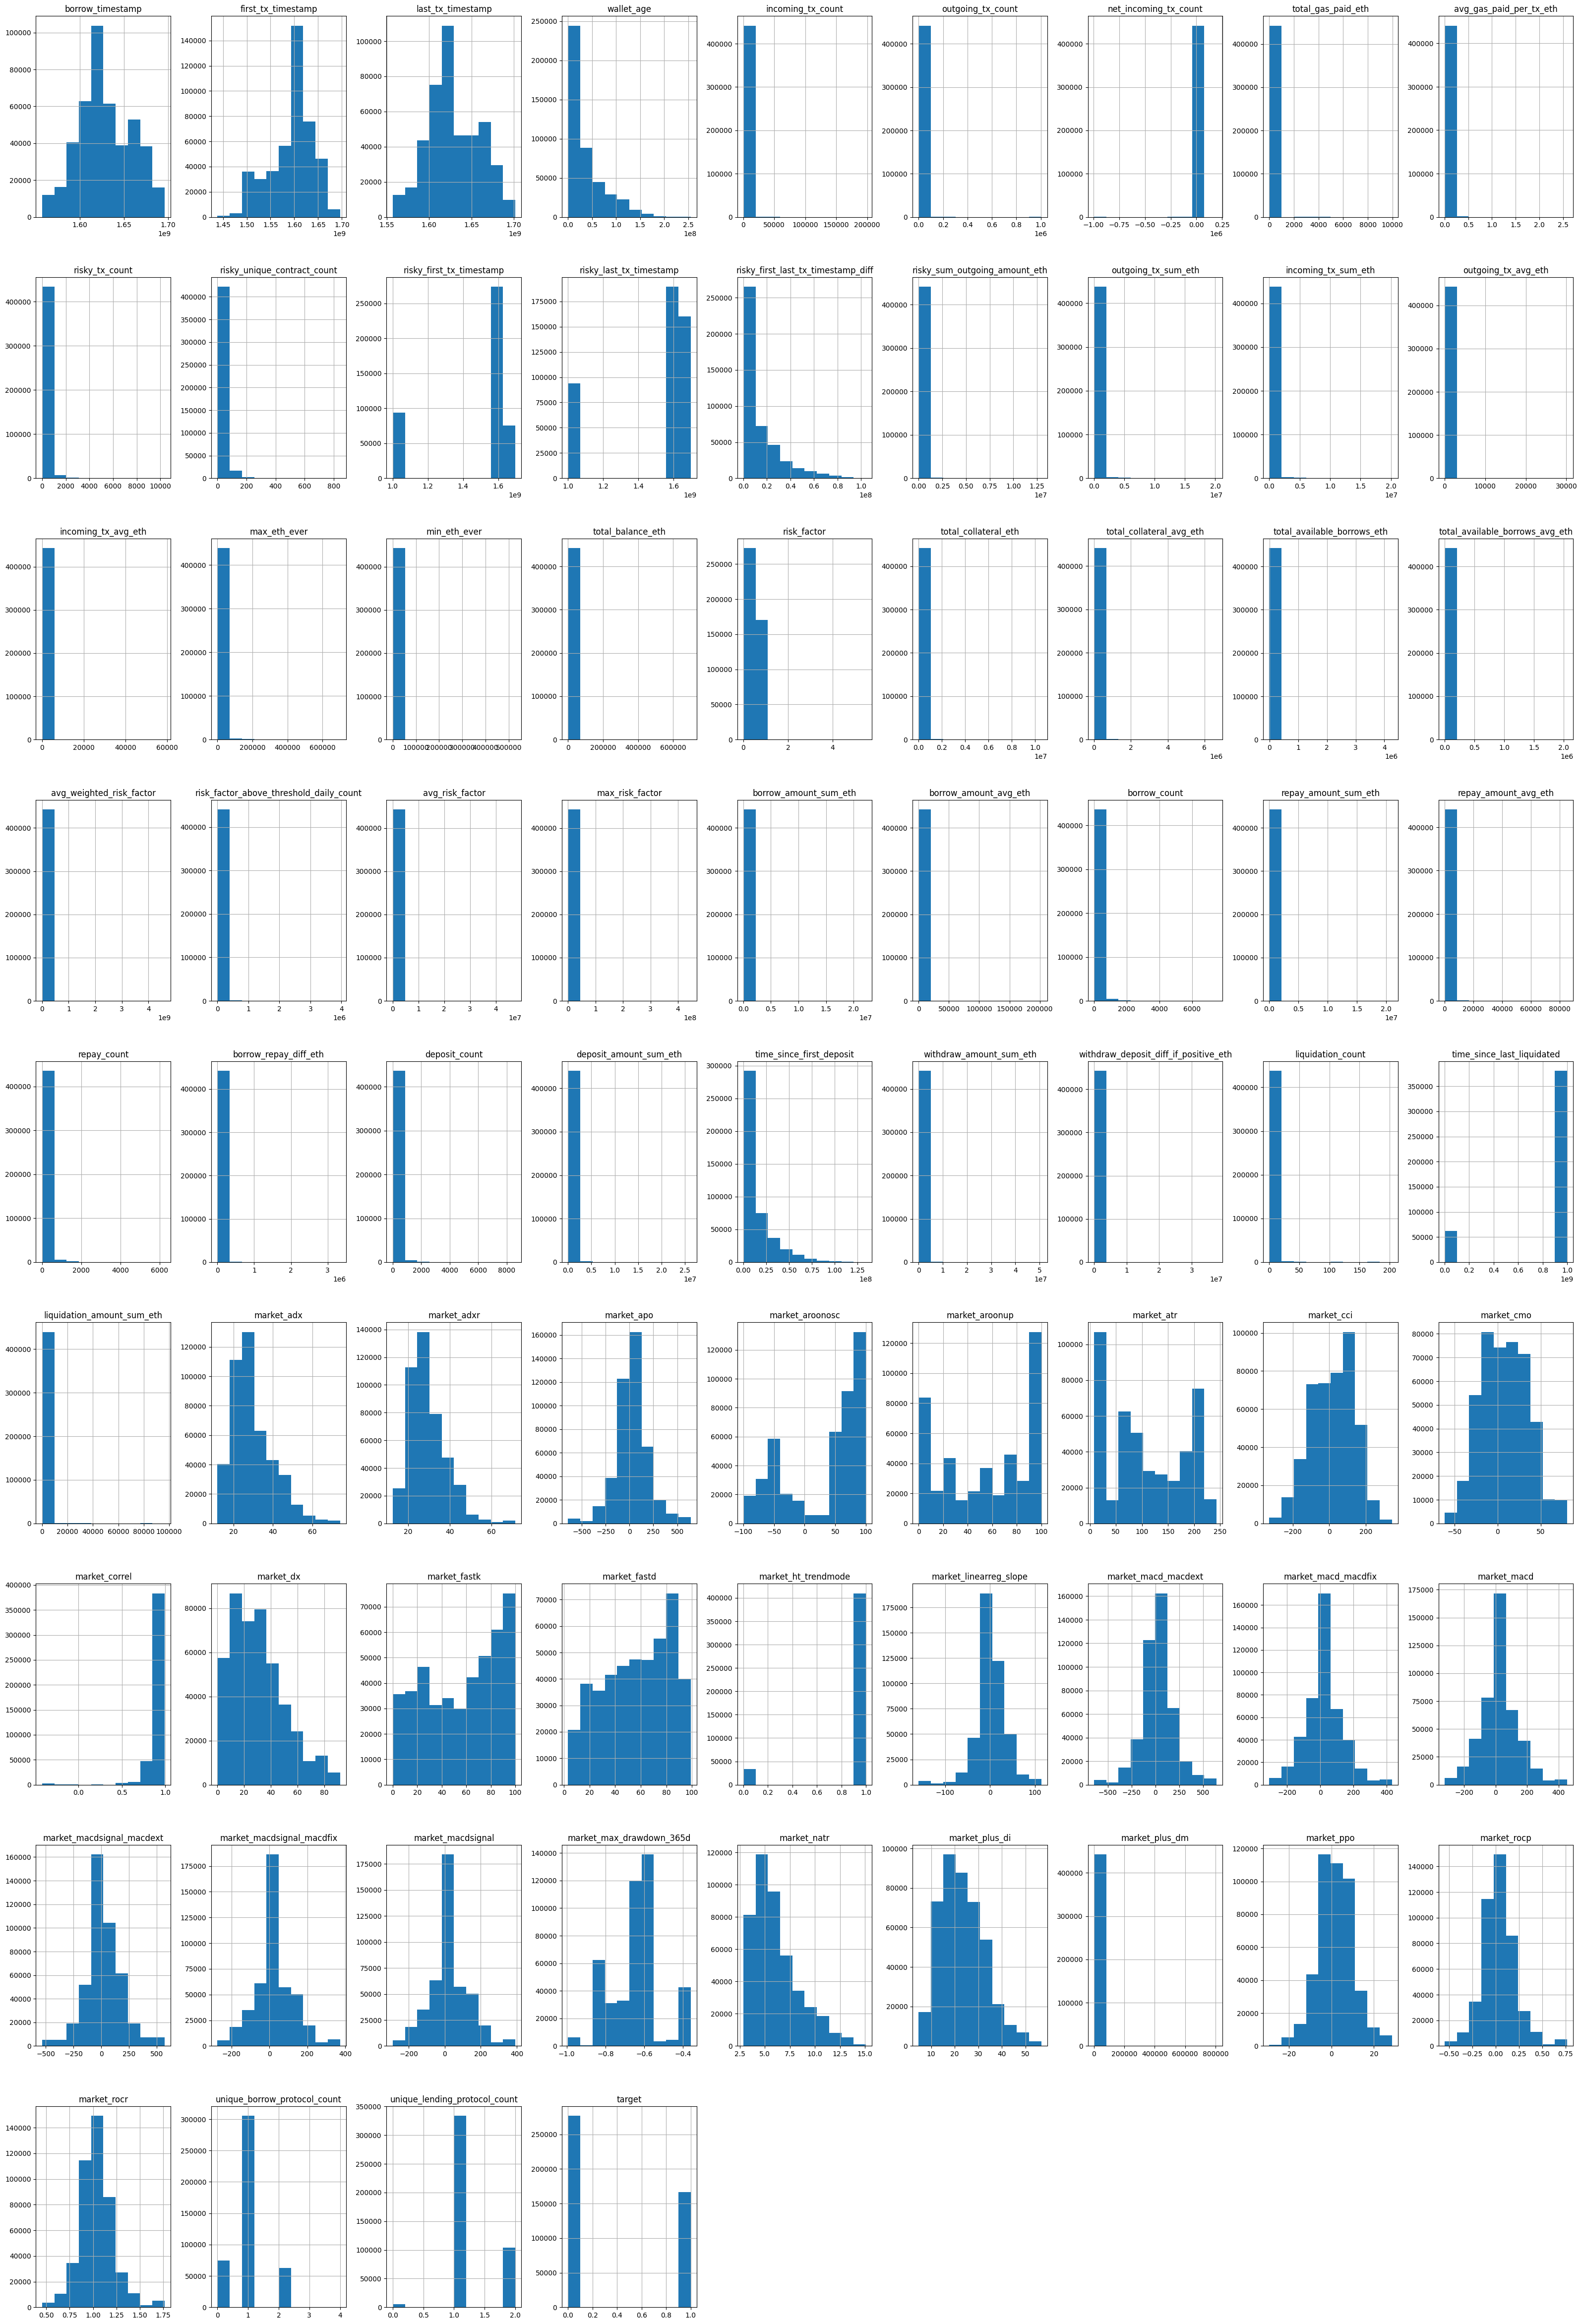

In [13]:
df.hist( figsize=(40, 60))

In [7]:
df = df.drop(columns=['wallet_address'])

In [8]:
X = df.drop(columns=['target'])
y = df['target']

In [9]:
X.select_dtypes(include=['object']).columns

Index([], dtype='object')

#Отбор признаком с низкой вариантивностью

In [10]:
from sklearn.feature_selection import VarianceThreshold
cols = X.columns
selector = VarianceThreshold(threshold=0.01)
df_num_filtered = selector.fit_transform(X)
selected_num_cols = cols[selector.get_support()]
len(selected_num_cols)

74

In [11]:
X = X [selected_num_cols]

отбор сколлерированных признаков

In [12]:
treshold_corr = 0.8
corr_matrix = df[X.columns].corr().abs()

to_drop = set()
for i in tqdm(range(len(X.columns))):
    for j in range(i + 1, len(X.columns)):
        col_i = X.columns[i]
        col_j = X.columns[j]
        if corr_matrix.loc[col_i, col_j] > treshold_corr:
            to_drop.add(col_j)

x_col_not_cor = [col for col in X.columns if col not in to_drop]

100%|██████████| 74/74 [00:00<00:00, 1171.48it/s]


In [13]:
len(x_col_not_cor)

48

In [14]:
X=X[x_col_not_cor]

Отбор незначимых признаков на основе статтеста ANOVA

In [16]:
from sklearn.feature_selection import f_classif
from scipy import stats
f_scores, p_values = f_classif(X, y)
anova_results = pd.DataFrame({
    'feature': X.columns,
    'F_score': f_scores,
    'p_value': p_values
}).sort_values(by='F_score', ascending=False)

anova_results

,feature,F_score,p_value
16,risk_factor,98388.808666,0.000000e+00
31,time_since_last_liquidated,50046.111653,0.000000e+00
0,borrow_timestamp,6284.218278,0.000000e+00
6,risky_tx_count,4228.970815,0.000000e+00
21,risk_factor_above_threshold_daily_count,4227.129727,0.000000e+00
25,borrow_count,3262.653272,0.000000e+00
46,unique_borrow_protocol_count,3169.100031,0.000000e+00
3,incoming_tx_count,2813.533328,0.000000e+00
27,borrow_repay_diff_eth,2319.868376,0.000000e+00
28,deposit_count,1676.570098,0.000000e+00


In [17]:
alpha = 0.05
significant_mask = p_values < alpha
X = X.loc[:, significant_mask]

In [74]:
X.shape

(442961, 43)

Метод обертки

In [ ]:
"""
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
"""

Отбор признаков с помощью L1 -регяляризации в логистической регрессии

In [ ]:
"""
pipeline_lin_coef= make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=42) )

params = {
    'logisticregression__C': [0.01],
    'logisticregression__penalty': ['l1'],
    'logisticregression__solver': ['liblinear']  }

grid_lin_coef = GridSearchCV(
    pipeline_lin_coef,
    params,
    cv=cv,
    scoring='accuracy',       
    n_jobs=-1,
    verbose=1
)
grid_lin_coef .fit(X_train, y_train)

# 2. Извлекаем лучшую модель из pipeline
best_model = grid_lin_coef .best_estimator_.named_steps['logisticregression']

# 3. Получаем коэффициенты
coef = best_model.coef_[0]  # для бинарной классификации
"""

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
"""
# 4. Получаем имена признаков (после preprocessor!)
feature_names = grid_lin_coef .best_estimator_.named_steps['columntransformer'].get_feature_names_out()

# 5. Отбираем признаки с ненулевыми коэффициентами
selected_features = feature_names[coef != 0]

print(f"Отобрано признаков: {len(selected_features)} из {len(feature_names)}")
print("Отобранные признаки:", selected_features.tolist())
"""

Отобрано признаков: 52 из 58
Отобранные признаки: ['borrow_timestamp', 'wallet_age', 'incoming_tx_count', 'outgoing_tx_count', 'total_gas_paid_eth', 'avg_gas_paid_per_tx_eth', 'risky_tx_count', 'risky_unique_contract_count', 'risky_first_tx_timestamp', 'risky_first_last_tx_timestamp_diff', 'risky_sum_outgoing_amount_eth', 'outgoing_tx_avg_eth', 'max_eth_ever', 'total_balance_eth', 'risk_factor', 'total_collateral_eth', 'total_collateral_avg_eth', 'total_available_borrows_eth', 'total_available_borrows_avg_eth', 'avg_weighted_risk_factor', 'risk_factor_above_threshold_daily_count', 'avg_risk_factor', 'borrow_amount_sum_eth', 'borrow_amount_avg_eth', 'borrow_count', 'repay_amount_avg_eth', 'borrow_repay_diff_eth', 'deposit_count', 'deposit_amount_sum_eth', 'time_since_first_deposit', 'withdraw_deposit_diff_if_positive_eth', 'liquidation_count', 'time_since_last_liquidated', 'market_adx', 'market_apo', 'market_aroonosc', 'market_aroonup', 'market_atr', 'market_cci', 'market_cmo', 'market_

# Логистическая регрессия

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


results = []

for col in tqdm(X.columns):
    X_single = X[[col]]
    
    # Создаём пайплайн: нормализация → модель
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000, random_state=42))
    ])
    
    # Кросс-валидация с нормализацией на каждом фолде
    auc_scores = cross_val_score(pipeline, X_single, y, cv=5, scoring='roc_auc')
    mean_auc = auc_scores.mean()
    
    results.append({
        'feature': col,
        'mean_auc': mean_auc,
        'std_auc': auc_scores.std()
    })

results_df = pd.DataFrame(results).sort_values(by='mean_auc', ascending=False)
results_df

 16%|█▋        | 7/43 [00:06<00:31,  1.14it/s]


KeyboardInterrupt: 

In [76]:
top_10_features = results_df.head(10)['feature'].tolist()
X_logreg = X[top_10_features]

In [19]:
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_logreg, y, random_state=42)

In [79]:
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [80]:
pipeline_linear= make_pipeline(preprocessor_1, LogisticRegression(max_iter=1000, random_state=42) )

In [81]:
params = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear']  
        }

grid_linear = GridSearchCV(
    pipeline_linear,
    params,
    cv=cv,
    scoring='roc_auc',       
    n_jobs=-1,
    verbose=1
)
grid_linear.fit(X_train, y_train)
print("Лучшие параметры:", grid_linear.best_params_)
print("Лучший скор (roc_auc):", grid_linear.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры: {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Лучший скор (roc_auc): 0.7698069912995853


# Дерево решений

In [82]:
results = []

for col in tqdm(X.columns):
    X_single = X[[col]]
    
    # Создаём простое дерево (без переобучения)
    model = DecisionTreeClassifier(
        max_depth=3,          # ограничиваем глубину, чтобы избежать переобучения на одном признаке
        min_samples_leaf=10,  # минимум объектов в листе
        random_state=42
    )
    
    # Оцениваем качество через кросс-валидацию (например, по accuracy или ROC-AUC)
    scores = cross_val_score(model, X_single, y, cv=5, scoring='roc_auc')  # или 'accuracy'
    results.append({
        'feature': col,
        'mean_score': scores.mean(),
        'std_score': scores.std()
    })

# Сортируем по убыванию качества
results_df = pd.DataFrame(results).sort_values(by='mean_score', ascending=False)
results_df.head(10)

100%|██████████| 43/43 [01:07<00:00,  1.58s/it]


,feature,mean_score,std_score
15,risk_factor,0.769507,0.019706
19,risk_factor_above_threshold_daily_count,0.743124,0.014126
28,time_since_last_liquidated,0.616585,0.020089
24,borrow_repay_diff_eth,0.613212,0.017829
22,borrow_count,0.612482,0.049577
25,deposit_count,0.605765,0.048198
18,avg_weighted_risk_factor,0.598614,0.022091
14,total_balance_eth,0.570191,0.013397
21,borrow_amount_avg_eth,0.569437,0.019037
13,min_eth_ever,0.557484,0.024960


In [89]:
top_10_features = results_df.head(10)['feature'].tolist()
X_tree = X[top_10_features]
X_train, X_test, y_train, y_test = train_test_split(X_tree, y, random_state=42)

In [90]:
model_tree = DecisionTreeClassifier()
params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}
grid_tree = GridSearchCV(
    model_tree,
    params,
    cv=cv,
    scoring='roc_auc',        
    n_jobs=-1,
    verbose=1
)
grid_tree.fit(X_train, y_train)
print("Лучшие параметры:", grid_tree.best_params_)
print("Лучший скор (roc_auc):", grid_tree.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Лучший скор (roc_auc): 0.853279428935348


# Случайный лес

In [46]:
# Обучаем RF на всех признаках
rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full.fit(X, y)
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_full.feature_importances_
}).sort_values('importance', ascending=False)
importances

,feature,importance
15,risk_factor,0.174112
19,risk_factor_above_threshold_daily_count,0.101763
28,time_since_last_liquidated,0.036088
26,time_since_first_deposit,0.032264
17,total_available_borrows_eth,0.029304
0,borrow_timestamp,0.026142
2,wallet_age,0.024694
13,min_eth_ever,0.023833
12,max_eth_ever,0.023798
16,total_collateral_eth,0.023435


In [45]:
top_features_rf = importances.head(10)['feature'].tolist()
X_rf = X[top_features_rf]
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, random_state=42)
rf_full.fit(X_train, y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [25]:
roc_auc_scores = cross_val_score(rf_full, X_train, y_train, cv=cv, scoring='roc_auc')
print("Средний ROC AUC:", roc_auc_scores.mean())

Средний ROC AUC: 0.9300861531821443


In [41]:
top_features_rf

['risk_factor',
 'risk_factor_above_threshold_daily_count',
 'time_since_last_liquidated',
 'time_since_first_deposit',
 'total_available_borrows_eth',
 'borrow_timestamp',
 'wallet_age',
 'min_eth_ever',
 'max_eth_ever',
 'total_collateral_eth']

In [42]:
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy 0.8708427772911569
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     69200
           1       0.90      0.74      0.81     41541

    accuracy                           0.87    110741
   macro avg       0.88      0.84      0.86    110741
weighted avg       0.87      0.87      0.87    110741



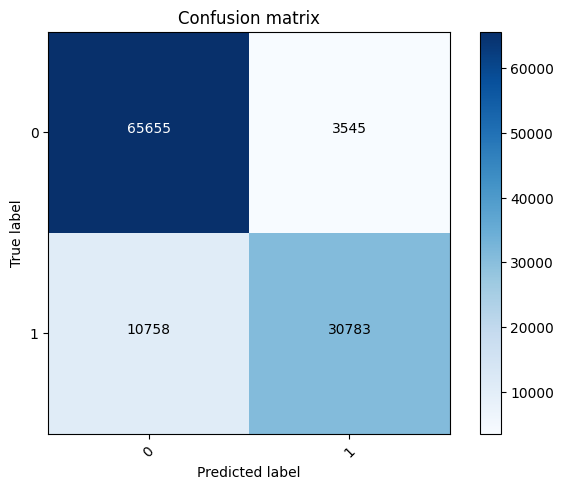

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, random_state=42)
rf_full.fit(X_train, y_train)
preds = rf_full.predict(X_test)
acc = accuracy_score(y_test, preds)
cm = confusion_matrix(y_test, preds)
print("accuracy", acc)

# Визуализация матрицы ошибок
plot_confusion_matrix(cm, classes=['0', '1'])

report = classification_report(y_test, preds, target_names=['0', '1'])
print(report)

# Сохранение модели в формате pickle
#with open('model.pkl', 'wb') as f:
#    pickle.dump(rf_full, f)

# boosting

In [30]:
from lightgbm import LGBMClassifier
model_boost = LGBMClassifier(
    n_estimators=300,
    max_depth=4,
    random_state=42
)
model_boost.fit(X, y)

[LightGBM] [Info] Number of positive: 166200, number of negative: 276761
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,161353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10002
[LightGBM] [Info] Number of data points in the train set: 442961, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,375202 -> initscore=-0,509962
[LightGBM] [Info] Start training from score -0,509962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,4
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [35]:
# Получаем важность — УБЕДИТЕСЬ, что это 1D массив
importances = model_boost.feature_importances_

# Отладочная проверка
print("Тип importances:", type(importances))
print("Форма importances:", importances.shape)

# Если вдруг двумерный — сожмём до 1D
if importances.ndim == 2:
    importances = importances.flatten()

# Имена признаков
if hasattr(X, 'columns'):
    feature_names = X.columns.tolist()
else:
    feature_names = [f'признак_{i}' for i in range(len(importances))]

# Создаём DataFrame
fi = pd.DataFrame({
    'Признак': feature_names,
    'Важность': importances
}).sort_values(by='Важность', ascending=False)

fi

Тип importances: <class 'numpy.ndarray'>
Форма importances: (43,)


,Признак,Важность
19,risk_factor_above_threshold_daily_count,297
15,risk_factor,256
0,borrow_timestamp,220
18,avg_weighted_risk_factor,215
26,time_since_first_deposit,174
13,min_eth_ever,150
32,market_atr,148
1,first_tx_timestamp,147
23,repay_amount_avg_eth,133
22,borrow_count,130


In [36]:
top_features_boost = fi.head(10)['Признак'].tolist()
X_boost = X[top_features_boost]
X_train, X_test, y_train, y_test = train_test_split(X_boost, y, random_state=42)

In [37]:
roc_auc_scores = cross_val_score(
    model_boost,
    X_test, y_test,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1  
)

# Выводим результаты
print(f"Средний ROC AUC: {roc_auc_scores.mean():.4f}")

Средний ROC AUC: 0.8809


Результаты хуже, чем у Случайного леса

In [39]:
import joblib

# После grid.fit()
best_model = rf_full

# Сохранить
joblib.dump(best_model, 'C:\Users\1213i\Desktop\DS\project\models\model_random_forest.pkl')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2867665391.py, line 7)

In [150]:
y_pred_test = grid_forest.predict(X_test)

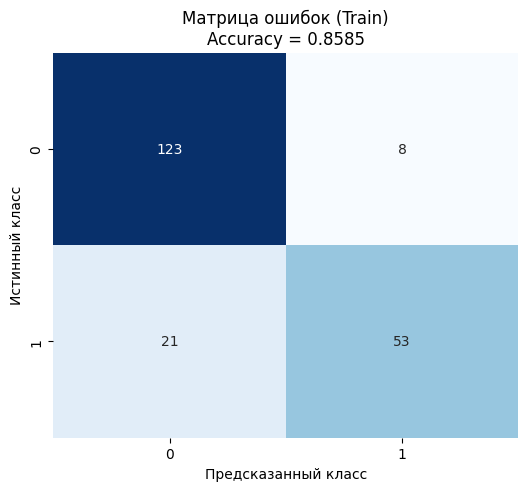

In [154]:
# 1. Матрица ошибок
cm = confusion_matrix(y_test, y_pred_test)

# 2. Accuracy
acc = accuracy_score(y_test, y_pred_test)

# 3. Визуализация матрицы ошибок
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Матрица ошибок (Train)\nAccuracy = {acc:.4f}')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()